In [1]:
import math
import torch
import gpytorch
import sys
sys.path.append("../cox-process/")
sys.path.append("../")
from cox_process import CoxProcess
from poisson_process import PoissonProcess
from gaussian_process import ExactGPModel

import matplotlib.pyplot as plt
import h5py
import numpy as np
from kernels import SpaceKernel
from torch.nn.functional import softplus

In [2]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, lh):
        super().__init__(train_x, train_y, lh)
        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = SpaceKernel()

    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [3]:
n = 15
dim = 3
inducing_pts = torch.zeros(pow(n, dim), dim)
for i in range(n):
    for j in range(n):
        for k in range(n):
            inducing_pts[i * n**2 + j * n + k][0] = float(i) / ((n-1) * 0.5) - 1.
            inducing_pts[i * n**2 + j * n + k][1] = float(j) / ((n-1) * 0.5) - 1.
            inducing_pts[i * n**2 + j * n + k][2] = float(k) / ((n-1) * 0.5) - 1.

inducing_row = torch.tensor([float(i) / ((n-1) * 0.5) - 1. for i in range(n)])

inducing_pts = inducing_pts.float()

In [4]:
f = h5py.File("../data/comoving-positions.h5", 'r')
dset = f['pos']
obs = torch.FloatTensor(dset[()])
num_obs = 1746 ## just taken from sample dataset

## Draw Points using True Covar

In [5]:
Ndraw = 15000
rs = np.cbrt(0.74**3*torch.rand(Ndraw).cpu().numpy())

In [6]:
cos_thetas = np.random.uniform(low=-1, high=1, size=Ndraw)
sin_thetas = np.sqrt(1-cos_thetas*cos_thetas)
phis = np.random.uniform(low=0, high=2*math.pi, size=Ndraw)

pts = np.column_stack((rs*np.cos(phis)*sin_thetas,
                rs*np.sin(phis)*sin_thetas,
                rs*cos_thetas))

rs = np.sqrt(np.sum(np.square(pts[:,np.newaxis,:] - pts[np.newaxis,:,:]), axis=2))

In [7]:
r_bao = torch.tensor(100/0.7/1000) # Gpc
w_bao = torch.tensor(15/0.7/1000) # Gpc
print(r_bao)
print(w_bao)
raw_r_bao = torch.log(torch.exp(r_bao) - 1)
raw_w_bao = torch.log(torch.exp(w_bao) - 1)

tensor(0.1429)
tensor(0.0214)


In [8]:
lh = gpytorch.likelihoods.GaussianLikelihood()
sample_model = GPModel(None, None, lh)

In [9]:
sample_model.covar_module.raw_gauss_mean.data = torch.log(torch.exp(r_bao) - 1)
sample_model.covar_module.raw_gauss_sig.data = torch.log(torch.exp(w_bao) - 1)

In [10]:
sample_model.eval()
lh.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [11]:
sample_intensity = sample_model(torch.tensor(pts).float()).sample(sample_shape=torch.Size((1,))).squeeze()
sample_intensity = sample_intensity.div(sample_intensity.max())
pts = pts[torch.rand(Ndraw).cpu() < sample_intensity.cpu(), :]
print('Drew {:d}'.format(pts.shape[0]))

Drew 1889


In [12]:
pts = torch.tensor(pts).float()


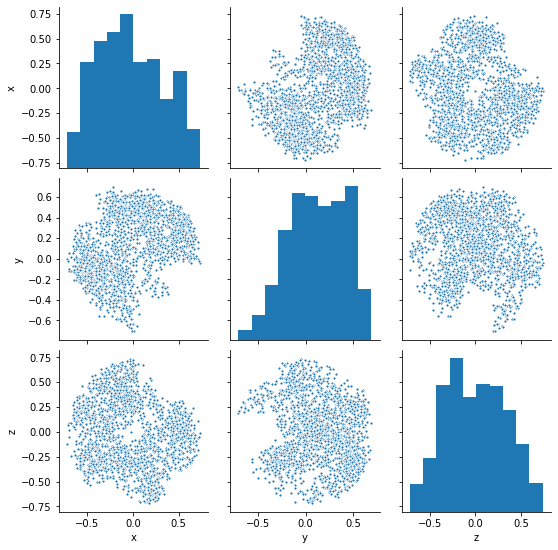

In [13]:
import seaborn as sns
import pandas as pd
plt_pts = pd.DataFrame(data=pts.numpy(), columns=['x', 'y', 'z'])
sns.pairplot(plt_pts, markers='.')

## Now perform inference

##### Set up grid kernel

In [29]:

grid_bounds = [(0, 1), (0, 1), (0, 1)]
grid_size = 25
grid = torch.zeros(grid_size, len(grid_bounds))
for i in range(len(grid_bounds)):
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
    grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, grid_bounds[i][1] + grid_diff, grid_size)


In [30]:
kern = gpytorch.kernels.GridKernel(SpaceKernel(), grid=grid)

In [31]:
cox_proc = CoxProcess(intensity_grid=inducing_pts, observations=pts,
                     kernel=kern, scale=False)

[]

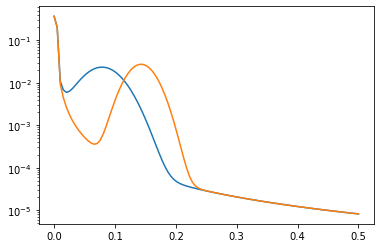

In [32]:
covar_mod = cox_proc.gaussian_process.covar_module
tau = torch.linspace(0, 0.5)
cov = covar_mod(tau, torch.zeros(1,1)).evaluate()

true_cov = sample_model.covar_module(tau, torch.zeros(1,1)).evaluate()
plt.plot(tau, cov.detach())
plt.plot(tau, true_cov.detach())
plt.semilogy()

In [33]:
for ii in range(1):
    inferred = cox_proc.stable_learn_intensity(iters=2)
    cox_proc.learn_hypers(iters=100);

2.7378060817718506
2.6299195289611816
2.5367331504821777
2.4592649936676025
2.3955581188201904
2.3439767360687256
2.302107572555542
2.267493724822998
2.2390129566192627
2.2143375873565674
2.192103624343872
2.1727683544158936
2.1549935340881348
2.139094114303589
2.1258370876312256
2.1139652729034424
2.1039724349975586
2.095101833343506
2.0874414443969727
2.0805206298828125
2.0746653079986572
2.069002151489258
2.064375400543213
2.060357093811035
2.0565569400787354
2.0537776947021484
2.051088571548462
2.0486903190612793
2.0468180179595947
2.0447888374328613
2.0434696674346924
2.0418155193328857
2.0406646728515625
2.039886951446533
2.038745164871216
2.037896156311035
2.0368165969848633
2.0363118648529053
2.0358569622039795
2.035022497177124
2.034557819366455
2.034034490585327
2.03383469581604
2.033572196960449
2.033112049102783
2.0330560207366943
2.0329537391662598
2.032759666442871
2.0326926708221436
2.0326309204101562
2.032397985458374
2.0322184562683105
2.0319693088531494
2.032034397125

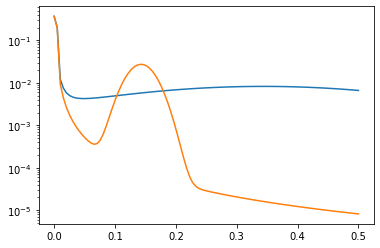

In [34]:
covar_mod = cox_proc.gaussian_process.covar_module
tau = torch.linspace(0, 0.5)
cov = covar_mod(tau, torch.zeros(1,1)).evaluate()
plt.plot(tau, cov.detach())
plt.plot(tau, true_cov.detach())
plt.yscale("log")